In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from utils import get_best_threshold
import torch

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

from utils import (
    print_confusion_matrix,
    get_prepared_train_test,
    get_best_metric_for_optuna,
    get_feature_to_importance,
)

In [4]:
train_data_raw = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__train.csv")
test_data_raw = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__test.csv")


In [ ]:
import torch
import torch.nn as nn

class BTCAddressVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 48),
            nn.ReLU(),
            nn.Linear(48, 32),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 48),
            nn.ReLU(),
            nn.Linear(48, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

def transform_dataset(df):
    df = df.drop(columns=[
        "class",
        "addrId",
        "Time step",
        "last_block_appeared_in",
    ])
    scaler = StandardScaler()
    df_transformed = scaler.fit_transform(df)

    return df_transformed

def add_vae_scores(df):
    df_prep = df.drop(columns=[
        'userId',
        'user_addr_cnt', 'user_outcoming_tx_cnt', 'user_incoming_tx_cnt',
        'user_input_users_cnt', 'user_output_users_cnt',
        'user_active_time_steps_cnt', 'user_btc_transacted_total',
        'user_btc_sent_total', 'user_btc_received_total',
        'user_btc_sent_median', 'user_btc_received_median',
        'user_interracted_output_address_cnt',
        'user_interracted_input_address_cnt', 'user_overall_activity_coef',
        'user_user_ts_fees_share_mean', 'user_user_ts_fees_share_min',
        'user_user_ts_fees_share_max', 'user_whole_fee_5',
    ])

    df_transformed = transform_dataset(df_prep)

    return df_transformed


def compute_reconstruction_errors(model, X_np, device='cuda'):
    model.eval()
    X_tensor = torch.tensor(X_np, dtype=torch.float32).to(device)
    with torch.no_grad():
        recon, mu, logvar = model(X_tensor)

        recon_loss = torch.mean((X_tensor - recon) ** 2, dim=1)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

        elbo = recon_loss + kl_div
        elbo_scores = elbo.cpu().numpy()

    return elbo_scores

vae = torch.load("./vae_wallets_150ep.pth")

In [27]:
# train_data_raw["vae_score"] = compute_reconstruction_errors(vae, add_vae_scores(train_data_raw), device="cpu")
test_data_raw["vae_score"] = compute_reconstruction_errors(vae, add_vae_scores(test_data_raw), device="cpu")

In [31]:
train_data_raw[train_data_raw["vae_score"] > 1]["vae_score"] = 1
test_data_raw[test_data_raw["vae_score"] > 1]["vae_score"] = 1

In [29]:
X_train, X_test, y_train, y_test = get_prepared_train_test(
    train_data_raw,
    test_data_raw,
)
X_train.shape, X_test.shape

((552376, 54), (281034, 54))

# XGB

In [32]:
import optuna
import xgboost as xgb
from utils import get_best_metric_for_optuna

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 60.0)
    }

    model = xgb.XGBClassifier(**params, random_state=42, eval_metric="logloss")

    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:,1]
    metric, thr = get_best_metric_for_optuna(y_pred, y_test, interval=(0.2, 0.4))
    print_confusion_matrix(y_pred, thr, y_test)
    print(f"Precicion = {precision_score((y_pred >= thr).astype(int), y_test)}")
    print(f"Recall = {recall_score((y_pred >= thr).astype(int), y_test)}")

    return metric

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

[I 2025-04-24 09:38:48,639] A new study created in memory with name: no-name-da5ff89e-f3fc-46e7-b9a8-0f4f7af09b22
[I 2025-04-24 09:38:54,833] Trial 0 finished with value: 0.23184593140011245 and parameters: {'n_estimators': 368, 'max_depth': 10, 'learning_rate': 0.01631181204069015, 'subsample': 0.9380799907976896, 'colsample_bytree': 0.5272923283200879, 'min_child_weight': 9, 'gamma': 3.6764784125583363, 'reg_alpha': 3.5487225686695045, 'reg_lambda': 4.507986662954533, 'scale_pos_weight': 49.37775120302034}. Best is trial 0 with value: 0.23184593140011245.


	real 1	real 0
pred 1	2309	29467	
pred 0	2196	247062	
Precicion = 0.5125416204217536
Recall = 0.07266490433031218


[I 2025-04-24 09:38:56,881] Trial 1 finished with value: 0.2690649306729794 and parameters: {'n_estimators': 95, 'max_depth': 11, 'learning_rate': 0.023845519736728132, 'subsample': 0.7647239474843105, 'colsample_bytree': 0.5950612328914131, 'min_child_weight': 8, 'gamma': 2.8744640076484345, 'reg_alpha': 8.420431449618338, 'reg_lambda': 2.5863160524643347, 'scale_pos_weight': 4.367417865116059}. Best is trial 1 with value: 0.2690649306729794.


	real 1	real 0
pred 1	1273	4363	
pred 0	3232	272166	
Precicion = 0.28257491675915647
Recall = 0.2258694109297374


[I 2025-04-24 09:38:59,322] Trial 2 finished with value: 0.24498003341924154 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.19198592864063313, 'subsample': 0.6613312070390535, 'colsample_bytree': 0.5743963925344189, 'min_child_weight': 8, 'gamma': 0.6003391682068787, 'reg_alpha': 4.347746499682046, 'reg_lambda': 6.523677300769299, 'scale_pos_weight': 42.41401686663733}. Best is trial 1 with value: 0.2690649306729794.


	real 1	real 0
pred 1	1730	15559	
pred 0	2775	260970	
Precicion = 0.38401775804661487
Recall = 0.10006362426976691


[I 2025-04-24 09:39:02,609] Trial 3 finished with value: 0.20319555401180966 and parameters: {'n_estimators': 390, 'max_depth': 14, 'learning_rate': 0.08195116175278176, 'subsample': 0.9997316433308927, 'colsample_bytree': 0.6865983345770328, 'min_child_weight': 10, 'gamma': 2.332504465396246, 'reg_alpha': 9.355120715842345, 'reg_lambda': 4.814335183212448, 'scale_pos_weight': 3.550525064374641}. Best is trial 1 with value: 0.2690649306729794.


	real 1	real 0
pred 1	936	4076	
pred 0	3569	272453	
Precicion = 0.20776914539400665
Recall = 0.18675179569034317


[I 2025-04-24 09:39:08,415] Trial 4 finished with value: 0.3071027831762678 and parameters: {'n_estimators': 257, 'max_depth': 14, 'learning_rate': 0.05300493573638667, 'subsample': 0.5550177362856363, 'colsample_bytree': 0.6323520233207618, 'min_child_weight': 1, 'gamma': 0.8548503149353198, 'reg_alpha': 7.23787106897677, 'reg_lambda': 3.634490867437601, 'scale_pos_weight': 40.540150145148765}. Best is trial 4 with value: 0.3071027831762678.


	real 1	real 0
pred 1	1675	7576	
pred 0	2830	268953	
Precicion = 0.37180910099889014
Recall = 0.18106150686412278


[I 2025-04-24 09:39:14,941] Trial 5 finished with value: 0.23459744975859365 and parameters: {'n_estimators': 378, 'max_depth': 9, 'learning_rate': 0.15966033012542133, 'subsample': 0.6631100569777815, 'colsample_bytree': 0.7999510220841681, 'min_child_weight': 10, 'gamma': 0.1948641077839347, 'reg_alpha': 7.092519138760734, 'reg_lambda': 3.5468110422787227, 'scale_pos_weight': 50.01120483334256}. Best is trial 4 with value: 0.3071027831762678.


	real 1	real 0
pred 1	1137	5076	
pred 0	3368	271453	
Precicion = 0.25238623751387346
Recall = 0.18300338000965716


[I 2025-04-24 09:39:17,008] Trial 6 finished with value: 0.21445783132530122 and parameters: {'n_estimators': 69, 'max_depth': 12, 'learning_rate': 0.016180313168862103, 'subsample': 0.6827550619932762, 'colsample_bytree': 0.7272460890827717, 'min_child_weight': 6, 'gamma': 4.041595500295846, 'reg_alpha': 2.317755971067761, 'reg_lambda': 9.593476096694783, 'scale_pos_weight': 43.55820292035089}. Best is trial 4 with value: 0.3071027831762678.


	real 1	real 0
pred 1	3560	61420	
pred 0	945	215109	
Precicion = 0.7902330743618202
Recall = 0.054786088027085254


[I 2025-04-24 09:39:21,885] Trial 7 finished with value: 0.21746293245469522 and parameters: {'n_estimators': 308, 'max_depth': 12, 'learning_rate': 0.25726349957468636, 'subsample': 0.6574449623556482, 'colsample_bytree': 0.950738558187882, 'min_child_weight': 7, 'gamma': 2.7571990149934704, 'reg_alpha': 4.098964568639859, 'reg_lambda': 5.7032707130476155, 'scale_pos_weight': 31.063947329658543}. Best is trial 4 with value: 0.3071027831762678.


	real 1	real 0
pred 1	1056	5204	
pred 0	3449	271325	
Precicion = 0.2344062153163152
Recall = 0.16869009584664538


[I 2025-04-24 09:39:23,866] Trial 8 finished with value: 0.41228617248752675 and parameters: {'n_estimators': 128, 'max_depth': 7, 'learning_rate': 0.0820624786716288, 'subsample': 0.5293644777304014, 'colsample_bytree': 0.8940381722576836, 'min_child_weight': 7, 'gamma': 3.512981101814004, 'reg_alpha': 9.99288310347298, 'reg_lambda': 5.060848815159101, 'scale_pos_weight': 1.3689332302564123}. Best is trial 8 with value: 0.41228617248752675.


	real 1	real 0
pred 1	1851	2577	
pred 0	2654	273952	
Precicion = 0.4108768035516093
Recall = 0.4180216802168022


[I 2025-04-24 09:39:27,751] Trial 9 finished with value: 0.2719213552181164 and parameters: {'n_estimators': 402, 'max_depth': 4, 'learning_rate': 0.04439349142455897, 'subsample': 0.962299776267147, 'colsample_bytree': 0.5043960865273818, 'min_child_weight': 7, 'gamma': 1.7887908364764027, 'reg_alpha': 2.965333403959023, 'reg_lambda': 4.835377761894111, 'scale_pos_weight': 52.35024903042681}. Best is trial 8 with value: 0.41228617248752675.


	real 1	real 0
pred 1	3098	35847	
pred 0	1407	240682	
Precicion = 0.6876803551609323
Recall = 0.07954808062652459


[I 2025-04-24 09:39:29,739] Trial 10 finished with value: 0.34123552795751966 and parameters: {'n_estimators': 168, 'max_depth': 3, 'learning_rate': 0.11472365510456616, 'subsample': 0.5008040873965491, 'colsample_bytree': 0.9953883777019008, 'min_child_weight': 3, 'gamma': 4.968890459417165, 'reg_alpha': 0.35026181419233726, 'reg_lambda': 0.35141556401478, 'scale_pos_weight': 17.148210632510313}. Best is trial 8 with value: 0.41228617248752675.


	real 1	real 0
pred 1	2352	14091	
pred 0	2153	262438	
Precicion = 0.5220865704772475
Recall = 0.14303959131545338


[I 2025-04-24 09:39:31,705] Trial 11 finished with value: 0.3828255035836815 and parameters: {'n_estimators': 183, 'max_depth': 3, 'learning_rate': 0.09002403327035428, 'subsample': 0.5052338283239309, 'colsample_bytree': 0.9874292747999276, 'min_child_weight': 3, 'gamma': 4.971197834725467, 'reg_alpha': 0.17066061659049936, 'reg_lambda': 0.21987186404862671, 'scale_pos_weight': 15.043050664189472}. Best is trial 8 with value: 0.41228617248752675.


	real 1	real 0
pred 1	2254	9165	
pred 0	2251	267364	
Precicion = 0.5003329633740289
Recall = 0.1973903143883002


[I 2025-04-24 09:39:34,528] Trial 12 finished with value: 0.2251759186864738 and parameters: {'n_estimators': 203, 'max_depth': 6, 'learning_rate': 0.0863520980793504, 'subsample': 0.5655204886071036, 'colsample_bytree': 0.8843090808845806, 'min_child_weight': 4, 'gamma': 4.973676877172288, 'reg_alpha': 5.744644952611011, 'reg_lambda': 0.14618744723108162, 'scale_pos_weight': 14.937317663284372}. Best is trial 8 with value: 0.41228617248752675.


	real 1	real 0
pred 1	1728	18622	
pred 0	2777	257907	
Precicion = 0.38357380688124304
Recall = 0.08491400491400491


[I 2025-04-24 09:39:40,239] Trial 13 finished with value: 0.22530257290830033 and parameters: {'n_estimators': 496, 'max_depth': 6, 'learning_rate': 0.0336144980952986, 'subsample': 0.5009060924877076, 'colsample_bytree': 0.8633710936951696, 'min_child_weight': 4, 'gamma': 3.7415663002874995, 'reg_alpha': 1.1282186497710267, 'reg_lambda': 7.592908722691214, 'scale_pos_weight': 14.315447751251508}. Best is trial 8 with value: 0.41228617248752675.


	real 1	real 0
pred 1	1627	16460	
pred 0	2878	260069	
Precicion = 0.3611542730299667
Recall = 0.08995411068723393


[I 2025-04-24 09:39:43,798] Trial 14 finished with value: 0.22747815607110575 and parameters: {'n_estimators': 229, 'max_depth': 8, 'learning_rate': 0.08349580982662054, 'subsample': 0.8233356403036054, 'colsample_bytree': 0.9128919983006318, 'min_child_weight': 1, 'gamma': 4.298060705729049, 'reg_alpha': 9.92448875938862, 'reg_lambda': 1.7154293631827726, 'scale_pos_weight': 22.893692003615428}. Best is trial 8 with value: 0.41228617248752675.


	real 1	real 0
pred 1	1510	13660	
pred 0	2995	262869	
Precicion = 0.33518312985571586
Recall = 0.0995385629531971


[I 2025-04-24 09:39:45,357] Trial 15 finished with value: 0.4502572898799314 and parameters: {'n_estimators': 110, 'max_depth': 4, 'learning_rate': 0.13037482804219627, 'subsample': 0.5872849873686836, 'colsample_bytree': 0.8119251153150765, 'min_child_weight': 3, 'gamma': 3.249040423563077, 'reg_alpha': 6.304209563655613, 'reg_lambda': 7.633738061260856, 'scale_pos_weight': 1.4304055656142647}. Best is trial 15 with value: 0.4502572898799314.


	real 1	real 0
pred 1	2100	3200	
pred 0	2405	273329	
Precicion = 0.46614872364039955
Recall = 0.39622641509433965


[I 2025-04-24 09:39:47,237] Trial 16 finished with value: 0.2964835164835165 and parameters: {'n_estimators': 124, 'max_depth': 5, 'learning_rate': 0.2994584511991537, 'subsample': 0.589580222293461, 'colsample_bytree': 0.7677530401239605, 'min_child_weight': 5, 'gamma': 3.159354977074984, 'reg_alpha': 5.700157762138359, 'reg_lambda': 8.261311671488782, 'scale_pos_weight': 2.3425501297930396}. Best is trial 15 with value: 0.4502572898799314.


	real 1	real 0
pred 1	1349	3381	
pred 0	3156	273148	
Precicion = 0.2994450610432852
Recall = 0.28520084566596193


[I 2025-04-24 09:39:48,586] Trial 17 finished with value: 0.29879007670336016 and parameters: {'n_estimators': 68, 'max_depth': 5, 'learning_rate': 0.1541077506178439, 'subsample': 0.6040248676502515, 'colsample_bytree': 0.8259414731599165, 'min_child_weight': 2, 'gamma': 1.9522640676516545, 'reg_alpha': 7.797514686984054, 'reg_lambda': 6.831341233360396, 'scale_pos_weight': 8.916459533530901}. Best is trial 15 with value: 0.4502572898799314.


	real 1	real 0
pred 1	1862	11277	
pred 0	2643	265252	
Precicion = 0.4133185349611543
Recall = 0.14171550346297282


[I 2025-04-24 09:39:50,957] Trial 18 finished with value: 0.2065460649011563 and parameters: {'n_estimators': 123, 'max_depth': 8, 'learning_rate': 0.03538568031362771, 'subsample': 0.7435956108942934, 'colsample_bytree': 0.8170710158906982, 'min_child_weight': 5, 'gamma': 3.3314377680965315, 'reg_alpha': 6.113721089576392, 'reg_lambda': 9.355764031496836, 'scale_pos_weight': 28.382869766600056}. Best is trial 15 with value: 0.4502572898799314.


	real 1	real 0
pred 1	1772	23104	
pred 0	2733	253425	
Precicion = 0.39334073251942286
Recall = 0.07123331725357775


[I 2025-04-24 09:39:54,614] Trial 19 finished with value: 0.3129138446403572 and parameters: {'n_estimators': 308, 'max_depth': 5, 'learning_rate': 0.010448201485885149, 'subsample': 0.8479691155996822, 'colsample_bytree': 0.7230434008379059, 'min_child_weight': 6, 'gamma': 1.2984692213798588, 'reg_alpha': 8.703975823893124, 'reg_lambda': 8.051498169764791, 'scale_pos_weight': 7.398144838869622}. Best is trial 15 with value: 0.4502572898799314.


	real 1	real 0
pred 1	1654	6755	
pred 0	2851	269774	
Precicion = 0.3671476137624861
Recall = 0.1966940183137115


[I 2025-04-24 09:39:55,984] Trial 20 finished with value: 0.22515922614597972 and parameters: {'n_estimators': 54, 'max_depth': 7, 'learning_rate': 0.11557820797242882, 'subsample': 0.6116178007428437, 'colsample_bytree': 0.9029191609185616, 'min_child_weight': 4, 'gamma': 2.380132868942522, 'reg_alpha': 6.718001679459443, 'reg_lambda': 6.027335970232542, 'scale_pos_weight': 22.91533139094285}. Best is trial 15 with value: 0.4502572898799314.


	real 1	real 0
pred 1	1506	13917	
pred 0	2999	262612	
Precicion = 0.33429522752497226
Recall = 0.09764637230110873


[I 2025-04-24 09:39:57,959] Trial 21 finished with value: 0.4181013280865716 and parameters: {'n_estimators': 181, 'max_depth': 3, 'learning_rate': 0.07169554270958485, 'subsample': 0.5372248901198771, 'colsample_bytree': 0.9961243249167977, 'min_child_weight': 3, 'gamma': 4.480767129991352, 'reg_alpha': 1.539793196039322, 'reg_lambda': 1.4409632807401465, 'scale_pos_weight': 10.461488961856357}. Best is trial 15 with value: 0.4502572898799314.


	real 1	real 0
pred 1	2210	6199	
pred 0	2295	270330	
Precicion = 0.49056603773584906
Recall = 0.2628136520394815


[I 2025-04-24 09:39:59,716] Trial 22 finished with value: 0.31873252562907733 and parameters: {'n_estimators': 122, 'max_depth': 4, 'learning_rate': 0.061278449561699345, 'subsample': 0.5538456061899208, 'colsample_bytree': 0.9482325855227193, 'min_child_weight': 2, 'gamma': 4.454669728951141, 'reg_alpha': 1.7840853644259005, 'reg_lambda': 1.6042833503824006, 'scale_pos_weight': 9.719329070672512}. Best is trial 15 with value: 0.4502572898799314.


	real 1	real 0
pred 1	1710	7095	
pred 0	2795	269434	
Precicion = 0.3795782463928968
Recall = 0.19420783645655879


[I 2025-04-24 09:40:02,112] Trial 23 finished with value: 0.19553265395321018 and parameters: {'n_estimators': 220, 'max_depth': 3, 'learning_rate': 0.06326189773803606, 'subsample': 0.5457338842812899, 'colsample_bytree': 0.8533795967808421, 'min_child_weight': 3, 'gamma': 3.5103712433305385, 'reg_alpha': 4.74138536720263, 'reg_lambda': 3.697638694790001, 'scale_pos_weight': 59.20341364880561}. Best is trial 15 with value: 0.4502572898799314.


	real 1	real 0
pred 1	3400	65522	
pred 0	1105	211007	
Precicion = 0.7547169811320755
Recall = 0.04933112794173123


[I 2025-04-24 09:40:04,237] Trial 24 finished with value: 0.270896141914624 and parameters: {'n_estimators': 154, 'max_depth': 4, 'learning_rate': 0.13561195568449014, 'subsample': 0.617274310358011, 'colsample_bytree': 0.9419526320040272, 'min_child_weight': 2, 'gamma': 4.4180472606761105, 'reg_alpha': 3.09631029024408, 'reg_lambda': 2.6094760284829794, 'scale_pos_weight': 2.128613578100124}. Best is trial 15 with value: 0.4502572898799314.


	real 1	real 0
pred 1	1240	3627	
pred 0	3265	272902	
Precicion = 0.27524972253052166
Recall = 0.25477707006369427


[I 2025-04-24 09:40:05,969] Trial 25 finished with value: 0.27680482584160343 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.215891728630206, 'subsample': 0.7056767690450696, 'colsample_bytree': 0.7813389602116225, 'min_child_weight': 7, 'gamma': 4.071180898091425, 'reg_alpha': 8.247555023316204, 'reg_lambda': 7.037378481999181, 'scale_pos_weight': 8.89112805418397}. Best is trial 15 with value: 0.4502572898799314.


	real 1	real 0
pred 1	1707	11107	
pred 0	2798	265422	
Precicion = 0.37891231964483907
Recall = 0.1332136725456532


[I 2025-04-24 09:40:09,067] Trial 26 finished with value: 0.3306346521751185 and parameters: {'n_estimators': 256, 'max_depth': 4, 'learning_rate': 0.1140138357085367, 'subsample': 0.5340645839778111, 'colsample_bytree': 0.8414787303973014, 'min_child_weight': 5, 'gamma': 3.080146889607678, 'reg_alpha': 5.252298824233538, 'reg_lambda': 1.4120920894991098, 'scale_pos_weight': 20.3857135446731}. Best is trial 15 with value: 0.4502572898799314.


	real 1	real 0
pred 1	2385	15662	
pred 0	2120	260867	
Precicion = 0.5294117647058824
Recall = 0.13215492879702997


[I 2025-04-24 09:40:12,173] Trial 27 finished with value: 0.2411810145051927 and parameters: {'n_estimators': 194, 'max_depth': 7, 'learning_rate': 0.07051960329910568, 'subsample': 0.5880305828277388, 'colsample_bytree': 0.9178847872478264, 'min_child_weight': 4, 'gamma': 3.8617856444470804, 'reg_alpha': 9.85886470004403, 'reg_lambda': 5.700360150545606, 'scale_pos_weight': 10.84497637429742}. Best is trial 15 with value: 0.4502572898799314.


	real 1	real 0
pred 1	1686	15247	
pred 0	2819	261282	
Precicion = 0.3742508324084351
Recall = 0.09956888915136125


[I 2025-04-24 09:40:14,071] Trial 28 finished with value: 0.4400247320692498 and parameters: {'n_estimators': 139, 'max_depth': 3, 'learning_rate': 0.04286409340745657, 'subsample': 0.6366505651525457, 'colsample_bytree': 0.9644962672508641, 'min_child_weight': 6, 'gamma': 2.644558774681641, 'reg_alpha': 6.520834218069601, 'reg_lambda': 8.93449213635719, 'scale_pos_weight': 1.43301810271322}. Best is trial 15 with value: 0.4502572898799314.


	real 1	real 0
pred 1	2135	4105	
pred 0	2370	272424	
Precicion = 0.4739178690344062
Recall = 0.3421474358974359


[I 2025-04-24 09:40:16,711] Trial 29 finished with value: 0.45057796650153337 and parameters: {'n_estimators': 292, 'max_depth': 3, 'learning_rate': 0.0268527550568105, 'subsample': 0.7210568188777587, 'colsample_bytree': 0.9994231238637574, 'min_child_weight': 3, 'gamma': 1.9607630648044978, 'reg_alpha': 6.398404836660824, 'reg_lambda': 8.408465423253636, 'scale_pos_weight': 5.92195388267108}. Best is trial 29 with value: 0.45057796650153337.


	real 1	real 0
pred 1	2292	5122	
pred 0	2213	271407	
Precicion = 0.5087680355160932
Recall = 0.3091448610736445


[I 2025-04-24 09:40:20,586] Trial 30 finished with value: 0.18043482125397756 and parameters: {'n_estimators': 336, 'max_depth': 5, 'learning_rate': 0.02220418667710282, 'subsample': 0.7346460764951187, 'colsample_bytree': 0.9594379004034127, 'min_child_weight': 6, 'gamma': 1.8436972548745154, 'reg_alpha': 6.261415290904596, 'reg_lambda': 8.871999583377079, 'scale_pos_weight': 31.601757067649594}. Best is trial 29 with value: 0.45057796650153337.


	real 1	real 0
pred 1	2030	36203	
pred 0	2475	240326	
Precicion = 0.4506104328523862
Recall = 0.053095493421913005


[I 2025-04-24 09:40:23,193] Trial 31 finished with value: 0.43559680833740433 and parameters: {'n_estimators': 282, 'max_depth': 3, 'learning_rate': 0.04365500275167121, 'subsample': 0.823868751683655, 'colsample_bytree': 0.9982666739141991, 'min_child_weight': 3, 'gamma': 1.3743809857438745, 'reg_alpha': 7.489892934285343, 'reg_lambda': 8.63427646065569, 'scale_pos_weight': 6.090223987177622}. Best is trial 29 with value: 0.45057796650153337.


	real 1	real 0
pred 1	2140	4404	
pred 0	2365	272125	
Precicion = 0.4750277469478357
Recall = 0.3270171149144254


[I 2025-04-24 09:40:25,956] Trial 32 finished with value: 0.45097731376089173 and parameters: {'n_estimators': 283, 'max_depth': 3, 'learning_rate': 0.028954664232226843, 'subsample': 0.7979545060734906, 'colsample_bytree': 0.9716139238731339, 'min_child_weight': 2, 'gamma': 1.3890764097115398, 'reg_alpha': 7.680066875654333, 'reg_lambda': 9.956320035536464, 'scale_pos_weight': 5.823803827107232}. Best is trial 32 with value: 0.45097731376089173.


	real 1	real 0
pred 1	2298	5160	
pred 0	2207	271369	
Precicion = 0.5100998890122087
Recall = 0.3081255028157683


[I 2025-04-24 09:40:29,213] Trial 33 finished with value: 0.43312075872782274 and parameters: {'n_estimators': 323, 'max_depth': 4, 'learning_rate': 0.023546874066020244, 'subsample': 0.878560411371949, 'colsample_bytree': 0.9658353466116998, 'min_child_weight': 1, 'gamma': 2.663715848787583, 'reg_alpha': 6.4619786103026895, 'reg_lambda': 9.955884118555193, 'scale_pos_weight': 5.421150198821267}. Best is trial 32 with value: 0.45097731376089173.


	real 1	real 0
pred 1	2119	4323	
pred 0	2386	272206	
Precicion = 0.47036625971143176
Recall = 0.32893511331884506


[I 2025-04-24 09:40:32,276] Trial 34 finished with value: 0.4698640449935787 and parameters: {'n_estimators': 348, 'max_depth': 3, 'learning_rate': 0.02864053164652721, 'subsample': 0.7774394951122556, 'colsample_bytree': 0.6744366729475927, 'min_child_weight': 2, 'gamma': 2.1039163401039027, 'reg_alpha': 8.215457523599191, 'reg_lambda': 7.631721953049942, 'scale_pos_weight': 1.1297759762658073}. Best is trial 34 with value: 0.4698640449935787.


	real 1	real 0
pred 1	2122	2439	
pred 0	2383	274090	
Precicion = 0.47103218645948947
Recall = 0.4652488489366367


[I 2025-04-24 09:40:36,525] Trial 35 finished with value: 0.43793854343092187 and parameters: {'n_estimators': 441, 'max_depth': 4, 'learning_rate': 0.028492389916642567, 'subsample': 0.77754052377927, 'colsample_bytree': 0.6326554255697883, 'min_child_weight': 2, 'gamma': 2.140332580163304, 'reg_alpha': 9.003567445831175, 'reg_lambda': 7.7182029876341876, 'scale_pos_weight': 5.812498886985379}. Best is trial 34 with value: 0.4698640449935787.


	real 1	real 0
pred 1	2172	4606	
pred 0	2333	271923	
Precicion = 0.4821309655937847
Recall = 0.3204485098849218


[I 2025-04-24 09:40:40,451] Trial 36 finished with value: 0.32751610126732555 and parameters: {'n_estimators': 344, 'max_depth': 5, 'learning_rate': 0.02001758078123435, 'subsample': 0.7830572157923061, 'colsample_bytree': 0.6530229718362109, 'min_child_weight': 2, 'gamma': 1.2182100906085778, 'reg_alpha': 8.078848252491046, 'reg_lambda': 9.419741118582573, 'scale_pos_weight': 12.401433670920625}. Best is trial 34 with value: 0.4698640449935787.


	real 1	real 0
pred 1	2207	13466	
pred 0	2298	263063	
Precicion = 0.48990011098779135
Recall = 0.14081541504498182


[I 2025-04-24 09:40:49,853] Trial 37 finished with value: 0.3165517043990956 and parameters: {'n_estimators': 422, 'max_depth': 15, 'learning_rate': 0.015514989627586965, 'subsample': 0.9038265107941814, 'colsample_bytree': 0.5576874283911625, 'min_child_weight': 1, 'gamma': 0.8347617049748035, 'reg_alpha': 7.274106535472402, 'reg_lambda': 7.434263193168944, 'scale_pos_weight': 36.02907628999075}. Best is trial 34 with value: 0.4698640449935787.


	real 1	real 0
pred 1	2212	14707	
pred 0	2293	261822	
Precicion = 0.4910099889012209
Recall = 0.1307405875051717


[I 2025-04-24 09:40:53,145] Trial 38 finished with value: 0.3375010214921958 and parameters: {'n_estimators': 362, 'max_depth': 3, 'learning_rate': 0.012928463121732278, 'subsample': 0.7174432613414693, 'colsample_bytree': 0.6875680487020092, 'min_child_weight': 1, 'gamma': 1.5541180987073588, 'reg_alpha': 6.907440597008061, 'reg_lambda': 9.96981329671247, 'scale_pos_weight': 18.02210101981811}. Best is trial 34 with value: 0.4698640449935787.


	real 1	real 0
pred 1	2478	16213	
pred 0	2027	260316	
Precicion = 0.5500554938956714
Recall = 0.1325771761810497


[I 2025-04-24 09:40:57,461] Trial 39 finished with value: 0.34503491078355314 and parameters: {'n_estimators': 271, 'max_depth': 10, 'learning_rate': 0.027161751587494544, 'subsample': 0.7949877311795415, 'colsample_bytree': 0.735183444066061, 'min_child_weight': 2, 'gamma': 2.1450553122616554, 'reg_alpha': 9.126463663913766, 'reg_lambda': 6.353665378754989, 'scale_pos_weight': 4.681159805189008}. Best is trial 34 with value: 0.4698640449935787.


	real 1	real 0
pred 1	1779	5981	
pred 0	2726	270548	
Precicion = 0.39489456159822417
Recall = 0.22925257731958762


In [33]:
import xgboost as xgb

def get_xgb_result_with_params(xgb_params, X_train, y_train, X_test, y_test):
    
    column_transformer = ColumnTransformer(
        transformers=[
            ('min_max_scale', MinMaxScaler(), list(set(X_train.columns))),
        ]
    )

    pipeline = Pipeline(steps=[
        ('transformers', column_transformer),
        ('xgb', xgb.XGBClassifier(**xgb_params))
    ])

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    res = get_best_threshold(y_pred, y_test, return_hists=True)

    return y_pred, pipeline.named_steps["xgb"].feature_importances_


        Best threshold: 0.10605263157894737
        Best F1: 0.394494623655914, precicion: 0.3220505617977528, recall: 0.5089900110987792
        


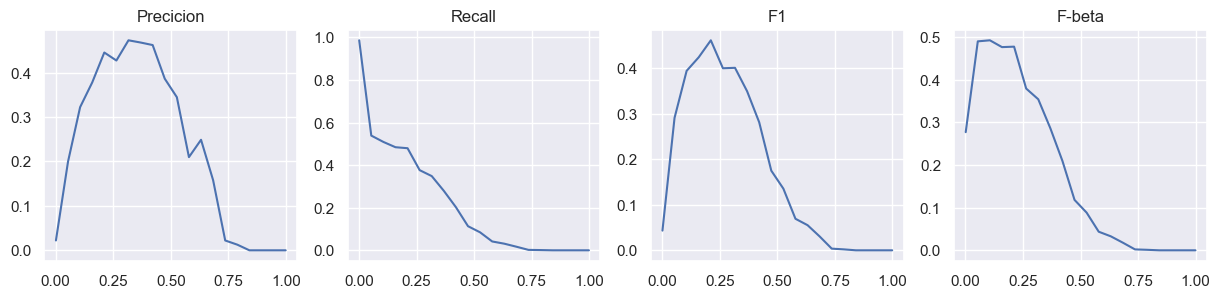

In [34]:
# best_params = {'n_estimators': 246, 'max_depth': 4, 'learning_rate': 0.01336443876805034, 'subsample': 0.6463282850483533, 'colsample_bytree': 0.8313068833483865, 'min_child_weight': 1, 'gamma': 1.8674512506957348, 'reg_alpha': 5.574491595970301, 'reg_lambda': 1.6836061653549808, 'scale_pos_weight': 7.286025143001134}

best_params = {'n_estimators': 297, 'max_depth': 3, 'learning_rate': 0.035945220741013736, 'subsample': 0.7341100732375431, 'colsample_bytree': 0.9953795550039859, 'min_child_weight': 4, 'gamma': 0.3909505373474582, 'reg_alpha': 7.311546429641343, 'reg_lambda': 0.9835545509646224, 'scale_pos_weight': 15.27610123192946}
# best_params = {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.026898887881948767, 'subsample': 0.7337002629923675, 'colsample_bytree': 0.9611689765248486, 'min_child_weight': 5, 'gamma': 1.8200795576345201, 'reg_alpha': 7.6485649310905215, 'reg_lambda': 0.07925701994769563, 'scale_pos_weight': 12.311320733333789}

# {'n_estimators': 486, 'max_depth': 3, 'learning_rate': 0.028967985258635896, 'subsample': 0.6624652961273084, 'colsample_bytree': 0.9999155266553814, 'min_child_weight': 5, 'gamma': 2.6185327073409113, 'reg_alpha': 8.037777763035855, 'reg_lambda': 0.042497566899104555, 'scale_pos_weight': 11.760089900261818}
# best_params =  {'n_estimators': 128, 'max_depth': 3, 'learning_rate': 0.053301522815073825, 'subsample': 0.6142219042316954, 'colsample_bytree': 0.810928044658756, 'min_child_weight': 10, 'gamma': 4.029095027044371, 'reg_alpha': 5.14441016145621, 'reg_lambda': 7.8633283614235765, 'scale_pos_weight': 10.04988404560164}
# best_params = {'n_estimators': 68, 'max_depth': 3, 'learning_rate': 0.018558114366149663, 'subsample': 0.8571131596931867, 'colsample_bytree': 0.7522095437546813, 'min_child_weight': 1, 'gamma': 0.00017002295883622454, 'reg_alpha': 4.867758688270761, 'reg_lambda': 1.0024950658030263, 'scale_pos_weight': 3.3442451255692065}


best_params = {'n_estimators': 348, 'max_depth': 3, 'learning_rate': 0.02864053164652721, 'subsample': 0.7774394951122556, 'colsample_bytree': 0.6744366729475927, 'min_child_weight': 2, 'gamma': 2.1039163401039027, 'reg_alpha': 8.215457523599191, 'reg_lambda': 7.631721953049942, 'scale_pos_weight': 1.1297759762658073}

best_pred, feature_imps = get_xgb_result_with_params(best_params, X_train, y_train, X_test, y_test)

In [39]:
from sklearn.metrics import classification_report
thr = 0.2
print_confusion_matrix(best_pred, thr, y_test, with_prec_rec=True)

report_dict = classification_report(y_test, (best_pred >= thr).astype(int), output_dict=True)
pd.DataFrame(report_dict)


	real 1	real 0
pred 1	2163	2768	
pred 0	2342	273761	
Precicion 0.4386534171567633, Recall 0.4801331853496115, 


,0,1,accuracy,macro avg,weighted avg
precision,0.991518,0.438653,0.981817,0.715086,0.982655
recall,0.989990,0.480133,0.981817,0.735062,0.981817
f1-score,0.990753,0.458457,0.981817,0.724605,0.982221
support,276529.000000,4505.000000,0.981817,281034.000000,281034.000000


In [43]:
get_feature_to_importance(
    X_train.columns,
    feature_imps
)

user_whole_fee_5 0.10824619
outcoming_tx_fees_max 0.07458464
outcoming_tx_ts_cnt 0.051286303
outcoming_tx_cnt 0.05053732
big_bct_received 0.047285844
user_btc_received_median 0.04245273
btc_received_max 0.042273484
btc_received_min 0.03950983
outcoming_tx_ts_gini 0.03839681
user_btc_received_total 0.03677454
incoming_tx_fees_max 0.03272836
incoming_tx_ts_cnt 0.02910885
user_user_ts_fees_share_max 0.028979747
btc_sent_total 0.027292026
incoming_tx_fees_min 0.02511287
incoming_tx_ts_gini 0.024933115
user_input_users_cnt 0.024093471
output_address_cnt 0.023479652
vae_score 0.023289032
outcoming_tx_output_address_cnt_mean 0.020889651
btc_sent_max 0.020711502
transacted_w_exchange_flg 0.019915529
user_incoming_tx_cnt 0.018280039
incoming_tx_cnt 0.017154273
btc_received_mean 0.01582709
user_btc_sent_total 0.015665341
lifetime_in_blocks 0.011940977
big_inp_addr 0.011640618
user_user_ts_fees_share_mean 0.0109224105
user_addr_cnt 0.01015703
btc_sent_gini 0.009300466
user_btc_sent_median 0.00923

### Analyze not found fraud

In [46]:
BASIC_FIELDS = [
    "btc_received_total",
    "btc_sent_total",
    "incoming_tx_cnt",
    "outcoming_tx_cnt",

    "incoming_tx_fees_max",
    "outcoming_tx_fees_max"
]

In [47]:
best_pred_classes = (best_pred >= 0.65).astype(int)
best_pred_classes

not_found_fraud = ((best_pred_classes == 0) & (y_test == 1)).astype(int)


X_test.iloc[np.array(not_found_fraud) == 1][BASIC_FIELDS]

,btc_received_total,btc_sent_total,incoming_tx_cnt,outcoming_tx_cnt,incoming_tx_fees_max,outcoming_tx_fees_max
1397,4.972163,4.571836,23.0,26.0,0.000500,0.000374
4465,0.000000,0.010054,0.0,1.0,0.000000,0.023540
6435,19.849708,0.036842,1.0,1.0,0.006539,0.004820
6590,0.120332,0.007525,2.0,1.0,0.000600,0.000947
7721,3.364271,1.507036,1.0,1.0,0.003729,0.119673
...,...,...,...,...,...,...
280971,0.048636,0.000000,1.0,0.0,0.000366,0.000000
280972,0.093456,0.000000,1.0,0.0,0.000802,0.000000
280973,0.093456,0.000000,1.0,0.0,0.000802,0.000000
280974,0.409053,0.000000,1.0,0.0,0.000947,0.000000


In [48]:
best_pred_classes = (best_pred >= 0.65).astype(int)
best_pred_classes

false_positive = ((best_pred_classes == 1) & (y_test == 0)).astype(int)


X_test.iloc[np.array(false_positive) == 1][BASIC_FIELDS]

,btc_received_total,btc_sent_total,incoming_tx_cnt,outcoming_tx_cnt,incoming_tx_fees_max,outcoming_tx_fees_max
245,0.000000,0.040000,0.0,1.0,0.000000,0.001000
270,0.000000,0.340260,0.0,1.0,0.000000,0.000740
287,0.000000,0.307058,0.0,1.0,0.000000,0.000588
315,0.028254,750.234006,4.0,2.0,0.000100,0.000421
890,0.000000,1.999500,0.0,1.0,0.000000,0.000500
...,...,...,...,...,...,...
262155,0.062220,0.000000,2.0,0.0,0.000334,0.000000
262331,0.238052,0.000000,6.0,0.0,0.000695,0.000000
264096,0.154768,0.000000,2.0,0.0,0.000500,0.000000
264706,0.050548,0.000000,1.0,0.0,0.000440,0.000000


In [25]:
y_test.sum()

np.int64(4505)

### Analyze accuracy on users

In [56]:
best_pred_classes = (best_pred >= 0.2).astype(int)
best_pred_classes


array([0, 0, 0, ..., 0, 0, 0])

In [57]:
addr_to_class = test_data_raw[["addrId", "userId"]]
addr_to_class["predicted_wallet_class"] = best_pred_classes
addr_to_class["real_wallet_classes"] = y_test

addr_to_class = addr_to_class \
    .merge(
        pd.read_csv("../dataset/custom/UserClasses.csv"),
        how="left",
        on="userId",
    ) \
    .rename(columns={"class": "user_class_true"})
addr_to_class["user_class_true"] = (addr_to_class["user_class_true"] == 1).astype(int)
addr_to_class


,addrId,userId,predicted_wallet_class,real_wallet_classes,user_class_true
0,1CDaGcM5SSmkExKz1DpYNPbmryUPvbyYiL,179247,0,0,0
1,1DtwQsqdqPHrgUtAAGANbiRnhwv2xXm6Jb,450134,0,0,0
2,12NaccU2hdbqii1upcgnuaGLEhsDpxshwK,13938,0,0,0
3,1BGTyzQRj12rYy6aRmUQsZYoCw5sMbz6MU,13938,0,0,0
4,1G5yHgUjmQQrusLr9Mb3YykBoFT3UW4dkz,440608,0,0,0
...,...,...,...,...,...
281029,13h3xr1LJXQXn9QR3gio62xgdZYAoBrKYQ,558019,0,0,0
281030,1Dow13WsGdCYewjtxP1acvM47A2XoPx1fF,316706,0,0,0
281031,18rfNEMrpF4yqw3s2Y9jTSvsfiH6dYC7ph,365639,0,0,0
281032,1Ct6Sx8uKTubXPcuLX5jSKb6QKMcqf1Ybj,245756,0,0,0


In [58]:
user_classes_all = pd.read_csv("../dataset/custom/UserClasses.csv")

user_classes_all[user_classes_all["userId"].isin(addr_to_class["userId"])]["class"].value_counts()

class
3    145087
2     44376
1      1397
Name: count, dtype: int64

In [59]:
user_to_predicted_class = addr_to_class.groupby("userId")["predicted_wallet_class"].max()
user_to_predicted_class = user_to_predicted_class.reset_index().rename(columns={"predicted_wallet_class": "user_class_pred"})

user_to_predicted_class = user_to_predicted_class \
    .merge(
        pd.read_csv("../dataset/custom/UserClasses.csv"),
        how="left",
        on="userId",
    ) \
    .rename(columns={"class": "user_class_true"})
user_to_predicted_class["user_class_true"] = (user_to_predicted_class["user_class_true"] == 1).astype(int)

print_confusion_matrix(
    np.array(user_to_predicted_class["user_class_pred"]),
    0.1,
    np.array(user_to_predicted_class["user_class_true"]),
)

	real 1	real 0
pred 1	498	1558	
pred 0	899	187905	


In [60]:
addr_to_class = addr_to_class.merge(
    user_to_predicted_class[["userId", "user_class_pred"]],
    how="left",
    on="userId"
)
addr_to_class

,addrId,userId,predicted_wallet_class,real_wallet_classes,user_class_true,user_class_pred
0,1CDaGcM5SSmkExKz1DpYNPbmryUPvbyYiL,179247,0,0,0,0
1,1DtwQsqdqPHrgUtAAGANbiRnhwv2xXm6Jb,450134,0,0,0,0
2,12NaccU2hdbqii1upcgnuaGLEhsDpxshwK,13938,0,0,0,0
3,1BGTyzQRj12rYy6aRmUQsZYoCw5sMbz6MU,13938,0,0,0,0
4,1G5yHgUjmQQrusLr9Mb3YykBoFT3UW4dkz,440608,0,0,0,0
...,...,...,...,...,...,...
281029,13h3xr1LJXQXn9QR3gio62xgdZYAoBrKYQ,558019,0,0,0,0
281030,1Dow13WsGdCYewjtxP1acvM47A2XoPx1fF,316706,0,0,0,0
281031,18rfNEMrpF4yqw3s2Y9jTSvsfiH6dYC7ph,365639,0,0,0,0
281032,1Ct6Sx8uKTubXPcuLX5jSKb6QKMcqf1Ybj,245756,0,0,0,0


In [61]:
addr_to_class["user_class_pred"].value_counts()

user_class_pred
0    256537
1     24497
Name: count, dtype: int64

In [62]:
user_to_addr = pd.read_csv("../dataset/custom/AddrUser.csv")
user_to_addr = user_to_addr.groupby("userId")["addrId"].nunique().reset_index()
user_to_addr = user_to_addr.merge(
        pd.read_csv("../dataset/custom/UserClasses.csv"),
        how="left",
        on="userId",
    )
user_to_addr["class"] = (user_to_addr["class"] == 1).astype(int)
users_with_many_addrs = user_to_addr[(user_to_addr["addrId"] >= 100) & (user_to_addr["addrId"] <= 1000)]
users_with_many_addrs.shape


(197, 3)

In [63]:
users_with_many_addrs.shape

(197, 3)

In [64]:
addr_to_class

,addrId,userId,predicted_wallet_class,real_wallet_classes,user_class_true,user_class_pred
0,1CDaGcM5SSmkExKz1DpYNPbmryUPvbyYiL,179247,0,0,0,0
1,1DtwQsqdqPHrgUtAAGANbiRnhwv2xXm6Jb,450134,0,0,0,0
2,12NaccU2hdbqii1upcgnuaGLEhsDpxshwK,13938,0,0,0,0
3,1BGTyzQRj12rYy6aRmUQsZYoCw5sMbz6MU,13938,0,0,0,0
4,1G5yHgUjmQQrusLr9Mb3YykBoFT3UW4dkz,440608,0,0,0,0
...,...,...,...,...,...,...
281029,13h3xr1LJXQXn9QR3gio62xgdZYAoBrKYQ,558019,0,0,0,0
281030,1Dow13WsGdCYewjtxP1acvM47A2XoPx1fF,316706,0,0,0,0
281031,18rfNEMrpF4yqw3s2Y9jTSvsfiH6dYC7ph,365639,0,0,0,0
281032,1Ct6Sx8uKTubXPcuLX5jSKb6QKMcqf1Ybj,245756,0,0,0,0


In [ ]:
addr_to_class["predicted_wallet_class_fixed"] = addr_to_class["predicted_wallet_class"]
users_with_many_addrs_list = set(users_with_many_addrs["userId"].tolist())


def func(row):
    if row["userId"] in users_with_many_addrs_list:
        return row["user_class_pred"]
    return row["predicted_wallet_class"]


addr_to_class["predicted_wallet_class_fixed"] = addr_to_class.apply(
    func, axis=1
)

In [66]:

print_confusion_matrix(
    np.array(addr_to_class["predicted_wallet_class"]),
    0.1,
    np.array(addr_to_class["real_wallet_classes"]),
)
precision_score(
    np.array(addr_to_class["predicted_wallet_class"]),
    np.array(addr_to_class["real_wallet_classes"]),
), recall_score(
    np.array(addr_to_class["predicted_wallet_class"]),
    np.array(addr_to_class["real_wallet_classes"]),
)

	real 1	real 0
pred 1	2163	2768	
pred 0	2342	273761	


(0.4801331853496115, 0.4386534171567633)

In [69]:

print_confusion_matrix(
    np.array(addr_to_class["predicted_wallet_class_fixed"]),
    0.1,
    np.array(addr_to_class["real_wallet_classes"]),
)
precision_score(
    np.array(addr_to_class["predicted_wallet_class_fixed"]),
    np.array(addr_to_class["real_wallet_classes"]),
), recall_score(
    np.array(addr_to_class["predicted_wallet_class_fixed"]),
    np.array(addr_to_class["real_wallet_classes"]),
)

	real 1	real 0
pred 1	2506	3600	
pred 0	1999	272929	


(0.5562708102108768, 0.4104159842777596)

In [70]:
(2506+272929)/(2506+272929+1999+3600)

0.980077143690799

In [177]:
classification_report(np.array(addr_to_class["real_wallet_classes"]), np.array(addr_to_class["predicted_wallet_class_fixed"]))

'              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99    276529\n           1       0.40      0.56      0.46      4505\n\n    accuracy                           0.98    281034\n   macro avg       0.69      0.77      0.73    281034\nweighted avg       0.98      0.98      0.98    281034\n'

In [ ]:

    # user_to_addr[user_to_addr["class"] == 1].shape, user_to_addr[user_to_addr["class"] == 1]["addrId"].value_counts()

(31280, 3)

In [89]:
user_to_addr[user_to_addr["class"] == 0]["addrId"].value_counts()

addrId
1       532816
2        16815
3         5307
4         2745
5         1529
         ...  
741          1
395          1
152          1
1104         1
92           1
Name: count, Length: 217, dtype: int64

In [137]:
addr_to_class[addr_to_class["user_class_true"] == 1].groupby("userId")["predicted_wallet_class"].nunique().value_counts()

predicted_wallet_class
1    1385
2      12
Name: count, dtype: int64

In [144]:
tm = addr_to_class[addr_to_class["user_class_true"] == 1].groupby("userId")["predicted_wallet_class"].nunique().reset_index()
tm = tm[tm["predicted_wallet_class"] == 2]

tm

,userId,predicted_wallet_class
0,4,2
1,32,2
4,128,2
13,244,2
16,367,2
20,539,2
26,927,2
39,2271,2
51,4741,2
72,10294,2


In [147]:
user_to_addr[user_to_addr["userId"] == 244]

,userId,addrId,class
243,244,5958,1


# XGB (no users)

In [57]:
X_train_no_users, X_test_no_users, y_train, y_test = get_prepared_train_test(
    train_data_raw,
    test_data_raw,
    type="no_users"
)
X_train_no_users.shape, X_test_no_users.shape

((552376, 33), (281034, 33))

In [59]:
X_train_no_users.head()

,btc_received_total,btc_received_min,btc_received_max,btc_received_mean,incoming_tx_cnt,incoming_tx_input_address_cnt_mean,incoming_tx_output_address_cnt_mean,btc_received_gini,input_address_cnt,incoming_tx_fees_min,...,outcoming_tx_fees_max,outcoming_tx_whole_fee_4_cnt,outcoming_tx_fees_total,outcoming_tx_ts_cnt,outcoming_tx_ts_gini,incoming_tx_ts_cnt,incoming_tx_ts_gini,lifetime_in_blocks,big_bct_received,big_inp_addr
0,6.999303,6.999303,6.999303,6.999303,1.0,1.0,2.0,0.0,1.0,0.0010,...,0.0010,1.0,0.0010,1.0,0.0,1.0,0.0,0.0,0,0
1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0001,1.0,0.0001,1.0,0.0,0.0,0.0,0.0,0,0
2,0.390310,0.390310,0.390310,0.390310,1.0,4.0,2.0,0.0,4.0,0.0001,...,0.0001,1.0,0.0001,1.0,0.0,1.0,0.0,8071.0,0,0
3,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0001,1.0,0.0001,1.0,0.0,0.0,0.0,0.0,0,0
4,3.200299,3.200299,3.200299,3.200299,1.0,1.0,2.0,0.0,1.0,0.0001,...,0.0001,1.0,0.0001,1.0,0.0,1.0,0.0,0.0,0,0


In [60]:
import optuna

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 60.0)
    }

    model = xgb.XGBClassifier(**params, random_state=42, eval_metric="logloss")

    model.fit(X_train_no_users, y_train)

    y_pred = model.predict_proba(X_test_no_users)[:,1]
    metric, thr = get_best_metric_for_optuna(y_pred, y_test)
    print_confusion_matrix(y_pred, thr, y_test)

    return metric

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-04-02 18:01:56,924] A new study created in memory with name: no-name-f3efee3c-3d7f-44be-960f-12950a88fde3
[I 2025-04-02 18:02:01,834] Trial 0 finished with value: 0.18319051813886442 and parameters: {'n_estimators': 379, 'max_depth': 14, 'learning_rate': 0.11601122770735801, 'subsample': 0.5137718281035082, 'colsample_bytree': 0.8776294035341927, 'min_child_weight': 7, 'gamma': 3.41805419090194, 'reg_alpha': 0.7010434743715777, 'reg_lambda': 5.043364656204115, 'scale_pos_weight': 7.3865672322787175}. Best is trial 0 with value: 0.18319051813886442.


	real 1	real 0
pred 1	915	6039	
pred 0	3590	270490	


[I 2025-04-02 18:02:06,331] Trial 1 finished with value: 0.1704414334223453 and parameters: {'n_estimators': 364, 'max_depth': 11, 'learning_rate': 0.10241623143120847, 'subsample': 0.8852853123029178, 'colsample_bytree': 0.6243531696501423, 'min_child_weight': 6, 'gamma': 2.1107804094218063, 'reg_alpha': 7.43257627085331, 'reg_lambda': 5.941860028828701, 'scale_pos_weight': 47.50833100954959}. Best is trial 0 with value: 0.18319051813886442.


	real 1	real 0
pred 1	1034	11279	
pred 0	3471	265250	


[I 2025-04-02 18:02:08,596] Trial 2 finished with value: 0.19354545099925885 and parameters: {'n_estimators': 244, 'max_depth': 5, 'learning_rate': 0.01407173918469413, 'subsample': 0.8243575223559436, 'colsample_bytree': 0.6513702584606416, 'min_child_weight': 9, 'gamma': 3.880058041824728, 'reg_alpha': 0.7379179570322036, 'reg_lambda': 6.414695258297303, 'scale_pos_weight': 54.58712994774269}. Best is trial 2 with value: 0.19354545099925885.


	real 1	real 0
pred 1	2977	55910	
pred 0	1528	220619	


[I 2025-04-02 18:02:11,186] Trial 3 finished with value: 0.2078452574037364 and parameters: {'n_estimators': 364, 'max_depth': 4, 'learning_rate': 0.2099850766511534, 'subsample': 0.9195984284562653, 'colsample_bytree': 0.9250602998031014, 'min_child_weight': 10, 'gamma': 2.0560024732523097, 'reg_alpha': 4.024343243085601, 'reg_lambda': 9.04863553125789, 'scale_pos_weight': 53.799959834446284}. Best is trial 3 with value: 0.2078452574037364.


	real 1	real 0
pred 1	2076	29845	
pred 0	2429	246684	


[I 2025-04-02 18:02:12,825] Trial 4 finished with value: 0.12291068715178119 and parameters: {'n_estimators': 139, 'max_depth': 14, 'learning_rate': 0.29997462742437403, 'subsample': 0.988835698245146, 'colsample_bytree': 0.9466130011922085, 'min_child_weight': 7, 'gamma': 1.562845206519004, 'reg_alpha': 7.122680306375393, 'reg_lambda': 6.713839626823716, 'scale_pos_weight': 51.04444883042056}. Best is trial 3 with value: 0.2078452574037364.


	real 1	real 0
pred 1	728	10867	
pred 0	3777	265662	


[I 2025-04-02 18:02:16,806] Trial 5 finished with value: 0.22511880515953836 and parameters: {'n_estimators': 464, 'max_depth': 6, 'learning_rate': 0.1529768067579743, 'subsample': 0.8766274291340819, 'colsample_bytree': 0.5542510034075209, 'min_child_weight': 3, 'gamma': 0.6960041943321449, 'reg_alpha': 5.747135741776028, 'reg_lambda': 6.019774427657442, 'scale_pos_weight': 51.44644983631065}. Best is trial 5 with value: 0.22511880515953836.


	real 1	real 0
pred 1	1658	17147	
pred 0	2847	259382	


[I 2025-04-02 18:02:21,042] Trial 6 finished with value: 0.14584796068168762 and parameters: {'n_estimators': 393, 'max_depth': 11, 'learning_rate': 0.040556705233783186, 'subsample': 0.9950809749733387, 'colsample_bytree': 0.6803324168785745, 'min_child_weight': 7, 'gamma': 2.6776366158685736, 'reg_alpha': 2.861018440521188, 'reg_lambda': 3.292222374197331, 'scale_pos_weight': 13.900930626372467}. Best is trial 5 with value: 0.22511880515953836.


	real 1	real 0
pred 1	914	12400	
pred 0	3591	264129	


[I 2025-04-02 18:02:22,622] Trial 7 finished with value: 0.30274211443968935 and parameters: {'n_estimators': 165, 'max_depth': 5, 'learning_rate': 0.08736400702990445, 'subsample': 0.8949447969701432, 'colsample_bytree': 0.9590922922668679, 'min_child_weight': 6, 'gamma': 4.93059871579762, 'reg_alpha': 6.848969580777697, 'reg_lambda': 0.7346592272958152, 'scale_pos_weight': 4.35905775527983}. Best is trial 7 with value: 0.30274211443968935.


	real 1	real 0
pred 1	1528	5688	
pred 0	2977	270841	


[I 2025-04-02 18:02:29,032] Trial 8 finished with value: 0.1476053720753442 and parameters: {'n_estimators': 486, 'max_depth': 11, 'learning_rate': 0.015504144580057711, 'subsample': 0.8360911140441758, 'colsample_bytree': 0.6549719757695784, 'min_child_weight': 5, 'gamma': 4.098112266301594, 'reg_alpha': 5.128645652822828, 'reg_lambda': 6.5381099383678585, 'scale_pos_weight': 40.442191637659}. Best is trial 7 with value: 0.30274211443968935.


	real 1	real 0
pred 1	1398	27938	
pred 0	3107	248591	


[I 2025-04-02 18:02:30,046] Trial 9 finished with value: 0.19077311361021415 and parameters: {'n_estimators': 70, 'max_depth': 5, 'learning_rate': 0.20271535259123433, 'subsample': 0.6924345924166015, 'colsample_bytree': 0.5566074665172653, 'min_child_weight': 8, 'gamma': 2.1251750996720524, 'reg_alpha': 7.240404791186062, 'reg_lambda': 2.0396643114132673, 'scale_pos_weight': 50.9332297493039}. Best is trial 7 with value: 0.30274211443968935.


	real 1	real 0
pred 1	2056	33810	
pred 0	2449	242719	


[I 2025-04-02 18:02:32,489] Trial 10 finished with value: 0.2226278745906884 and parameters: {'n_estimators': 215, 'max_depth': 7, 'learning_rate': 0.04949299713607139, 'subsample': 0.7241651506492124, 'colsample_bytree': 0.8117445594277664, 'min_child_weight': 1, 'gamma': 4.902291211298407, 'reg_alpha': 9.75360752178439, 'reg_lambda': 0.5331972401628915, 'scale_pos_weight': 23.207403620392974}. Best is trial 7 with value: 0.30274211443968935.


	real 1	real 0
pred 1	2366	32752	
pred 0	2139	243777	


[I 2025-04-02 18:02:34,418] Trial 11 finished with value: 0.18843673253919072 and parameters: {'n_estimators': 162, 'max_depth': 7, 'learning_rate': 0.08958740728752099, 'subsample': 0.7935893620292448, 'colsample_bytree': 0.5053479516797128, 'min_child_weight': 3, 'gamma': 0.034760030484000115, 'reg_alpha': 5.712251790730937, 'reg_lambda': 3.7190201028635124, 'scale_pos_weight': 29.333254989861146}. Best is trial 7 with value: 0.30274211443968935.


	real 1	real 0
pred 1	1642	23907	
pred 0	2863	252622	


[I 2025-04-02 18:02:37,449] Trial 12 finished with value: 0.3831020477238111 and parameters: {'n_estimators': 498, 'max_depth': 3, 'learning_rate': 0.032096215467556935, 'subsample': 0.6526205291345932, 'colsample_bytree': 0.7657285731034092, 'min_child_weight': 4, 'gamma': 0.5597409684953621, 'reg_alpha': 9.303964985041036, 'reg_lambda': 8.729302961172813, 'scale_pos_weight': 1.62574962922008}. Best is trial 12 with value: 0.3831020477238111.


	real 1	real 0
pred 1	1811	3805	
pred 0	2694	272724	


[I 2025-04-02 18:02:39,532] Trial 13 finished with value: 0.3842448657879757 and parameters: {'n_estimators': 301, 'max_depth': 3, 'learning_rate': 0.02952682506691833, 'subsample': 0.6450211787261498, 'colsample_bytree': 0.7796538829148326, 'min_child_weight': 4, 'gamma': 1.1024936143845745, 'reg_alpha': 9.825978912344024, 'reg_lambda': 9.013497779576879, 'scale_pos_weight': 2.725196474156631}. Best is trial 13 with value: 0.3842448657879757.


	real 1	real 0
pred 1	1755	3062	
pred 0	2750	273467	


[I 2025-04-02 18:02:41,555] Trial 14 finished with value: 0.3822220301629143 and parameters: {'n_estimators': 299, 'max_depth': 3, 'learning_rate': 0.02638831943902743, 'subsample': 0.6261902940803121, 'colsample_bytree': 0.7899747019645718, 'min_child_weight': 4, 'gamma': 0.9840180553151116, 'reg_alpha': 8.856367077417179, 'reg_lambda': 9.561811797223202, 'scale_pos_weight': 1.0697678250719858}. Best is trial 13 with value: 0.3842448657879757.


	real 1	real 0
pred 1	1769	3352	
pred 0	2736	273177	


[I 2025-04-02 18:02:43,639] Trial 15 finished with value: 0.314934448033441 and parameters: {'n_estimators': 297, 'max_depth': 3, 'learning_rate': 0.02866892564618799, 'subsample': 0.6066401552572197, 'colsample_bytree': 0.7370174934318061, 'min_child_weight': 2, 'gamma': 4.912008583612959e-05, 'reg_alpha': 9.997508399628655, 'reg_lambda': 8.529403427284084, 'scale_pos_weight': 15.791344680784619}. Best is trial 13 with value: 0.3842448657879757.


	real 1	real 0
pred 1	1989	11569	
pred 0	2516	264960	


[I 2025-04-02 18:02:48,747] Trial 16 finished with value: 0.1886810908094996 and parameters: {'n_estimators': 443, 'max_depth': 9, 'learning_rate': 0.010043890469087583, 'subsample': 0.6351842727415248, 'colsample_bytree': 0.851374445691351, 'min_child_weight': 4, 'gamma': 0.922653387523299, 'reg_alpha': 8.465445197627103, 'reg_lambda': 7.950467145917196, 'scale_pos_weight': 13.317883917300765}. Best is trial 13 with value: 0.3842448657879757.


	real 1	real 0
pred 1	1929	31169	
pred 0	2576	245360	


[I 2025-04-02 18:02:53,360] Trial 17 finished with value: 0.21516852452104251 and parameters: {'n_estimators': 423, 'max_depth': 8, 'learning_rate': 0.02939266021250709, 'subsample': 0.5312608406528927, 'colsample_bytree': 0.7334838183600126, 'min_child_weight': 4, 'gamma': 1.299576897294092, 'reg_alpha': 8.531331939303831, 'reg_lambda': 9.797541763167484, 'scale_pos_weight': 21.06845455506819}. Best is trial 13 with value: 0.3842448657879757.


	real 1	real 0
pred 1	1633	18294	
pred 0	2872	258235	


[I 2025-04-02 18:02:55,530] Trial 18 finished with value: 0.33771679054697923 and parameters: {'n_estimators': 323, 'max_depth': 3, 'learning_rate': 0.06131920893521108, 'subsample': 0.6796652991318954, 'colsample_bytree': 0.7696138472680858, 'min_child_weight': 1, 'gamma': 0.5110763240964972, 'reg_alpha': 3.156748357402643, 'reg_lambda': 7.559159958957658, 'scale_pos_weight': 8.24596941392215}. Best is trial 13 with value: 0.3842448657879757.


	real 1	real 0
pred 1	1772	6443	
pred 0	2733	270086	


[I 2025-04-02 18:03:01,323] Trial 19 finished with value: 0.1817569211762724 and parameters: {'n_estimators': 495, 'max_depth': 9, 'learning_rate': 0.018054663195652715, 'subsample': 0.5722496261026843, 'colsample_bytree': 0.8547155159122299, 'min_child_weight': 5, 'gamma': 1.5413209436725501, 'reg_alpha': 9.370136738281303, 'reg_lambda': 7.6066432333322584, 'scale_pos_weight': 36.92810321451982}. Best is trial 13 with value: 0.3842448657879757.


	real 1	real 0
pred 1	1942	33461	
pred 0	2563	243068	


[I 2025-04-02 18:03:02,378] Trial 20 finished with value: 0.2778511785223549 and parameters: {'n_estimators': 78, 'max_depth': 4, 'learning_rate': 0.039704186952299034, 'subsample': 0.7573171404748458, 'colsample_bytree': 0.7090058169472826, 'min_child_weight': 3, 'gamma': 3.008765566210064, 'reg_alpha': 7.854424585631575, 'reg_lambda': 8.60959659467405, 'scale_pos_weight': 21.539049057055983}. Best is trial 13 with value: 0.3842448657879757.


	real 1	real 0
pred 1	2103	17721	
pred 0	2402	258808	


[I 2025-04-02 18:03:04,270] Trial 21 finished with value: 0.3800256629597947 and parameters: {'n_estimators': 261, 'max_depth': 3, 'learning_rate': 0.024292925153904573, 'subsample': 0.6455325320385682, 'colsample_bytree': 0.7797588335088765, 'min_child_weight': 4, 'gamma': 0.8440946423727834, 'reg_alpha': 8.818272172326875, 'reg_lambda': 9.81034715607413, 'scale_pos_weight': 2.794759684743722}. Best is trial 13 with value: 0.3842448657879757.


	real 1	real 0
pred 1	1777	3583	
pred 0	2728	272946	


[I 2025-04-02 18:03:06,774] Trial 22 finished with value: 0.38747884940778343 and parameters: {'n_estimators': 321, 'max_depth': 4, 'learning_rate': 0.022029883317184456, 'subsample': 0.6032198341257682, 'colsample_bytree': 0.811054958759173, 'min_child_weight': 2, 'gamma': 0.4185327809074679, 'reg_alpha': 9.047825559667798, 'reg_lambda': 9.991007132661824, 'scale_pos_weight': 3.081360078594262}. Best is trial 22 with value: 0.38747884940778343.


	real 1	real 0
pred 1	1832	3788	
pred 0	2673	272741	


[I 2025-04-02 18:03:09,392] Trial 23 finished with value: 0.3651148607440537 and parameters: {'n_estimators': 335, 'max_depth': 4, 'learning_rate': 0.02019984616508935, 'subsample': 0.5787814260838069, 'colsample_bytree': 0.8976984520320701, 'min_child_weight': 2, 'gamma': 0.3730994143566624, 'reg_alpha': 9.896339514798298, 'reg_lambda': 8.881697998730722, 'scale_pos_weight': 9.197236707708871}. Best is trial 22 with value: 0.38747884940778343.


	real 1	real 0
pred 1	1796	4779	
pred 0	2709	271750	


[I 2025-04-02 18:03:11,618] Trial 24 finished with value: 0.2291895227646736 and parameters: {'n_estimators': 221, 'max_depth': 6, 'learning_rate': 0.06063003909755076, 'subsample': 0.6789997418208361, 'colsample_bytree': 0.8277379905198705, 'min_child_weight': 2, 'gamma': 1.2851232173168161, 'reg_alpha': 8.084689194167296, 'reg_lambda': 7.943685810849822, 'scale_pos_weight': 11.768344751071421}. Best is trial 22 with value: 0.38747884940778343.


	real 1	real 0
pred 1	1337	9811	
pred 0	3168	266718	


[I 2025-04-02 18:03:14,587] Trial 25 finished with value: 0.37530373315661586 and parameters: {'n_estimators': 415, 'max_depth': 4, 'learning_rate': 0.037031806554740726, 'subsample': 0.553620717296419, 'colsample_bytree': 0.7022855273374803, 'min_child_weight': 3, 'gamma': 0.35401334495612924, 'reg_alpha': 6.362953946715608, 'reg_lambda': 9.792138403200434, 'scale_pos_weight': 1.2696568081257984}. Best is trial 22 with value: 0.38747884940778343.


	real 1	real 0
pred 1	1699	2916	
pred 0	2806	273613	


[I 2025-04-02 18:03:17,924] Trial 26 finished with value: 0.2697836237678152 and parameters: {'n_estimators': 340, 'max_depth': 6, 'learning_rate': 0.011441798704573408, 'subsample': 0.7296990583491407, 'colsample_bytree': 0.8109770908995813, 'min_child_weight': 5, 'gamma': 1.5922986261568686, 'reg_alpha': 9.154110852879217, 'reg_lambda': 7.085336099023927, 'scale_pos_weight': 17.634867984903035}. Best is trial 22 with value: 0.38747884940778343.


	real 1	real 0
pred 1	1768	12979	
pred 0	2737	263550	


[I 2025-04-02 18:03:20,459] Trial 27 finished with value: 0.37300815757217126 and parameters: {'n_estimators': 288, 'max_depth': 5, 'learning_rate': 0.022104570944915025, 'subsample': 0.5996351037653846, 'colsample_bytree': 0.7531337351786189, 'min_child_weight': 2, 'gamma': 0.28991742569304574, 'reg_alpha': 7.909371953418559, 'reg_lambda': 5.2117772508612985, 'scale_pos_weight': 5.706933634195327}. Best is trial 22 with value: 0.38747884940778343.


	real 1	real 0
pred 1	1765	3874	
pred 0	2740	272655	


[I 2025-04-02 18:03:22,090] Trial 28 finished with value: 0.22562373311610814 and parameters: {'n_estimators': 203, 'max_depth': 3, 'learning_rate': 0.03338092111971992, 'subsample': 0.6580790784246541, 'colsample_bytree': 0.9970354054489632, 'min_child_weight': 1, 'gamma': 1.1733876916885768, 'reg_alpha': 9.193163238229646, 'reg_lambda': 9.027860778212977, 'scale_pos_weight': 29.836423734950596}. Best is trial 22 with value: 0.38747884940778343.


	real 1	real 0
pred 1	2382	32385	
pred 0	2123	244144	


[I 2025-04-02 18:03:27,936] Trial 29 finished with value: 0.25066009505368775 and parameters: {'n_estimators': 393, 'max_depth': 13, 'learning_rate': 0.04949956269643243, 'subsample': 0.504798403703785, 'colsample_bytree': 0.8802730498333252, 'min_child_weight': 6, 'gamma': 1.7696406470797752, 'reg_alpha': 6.5442045107950095, 'reg_lambda': 8.319074662813652, 'scale_pos_weight': 10.08454520727597}. Best is trial 22 with value: 0.38747884940778343.


	real 1	real 0
pred 1	1424	8961	
pred 0	3081	267568	



        Best threshold: 0.15857894736842104
        Best F1: 0.3023148148148148, precicion: 0.23169722057953873, recall: 0.434850166481687
        


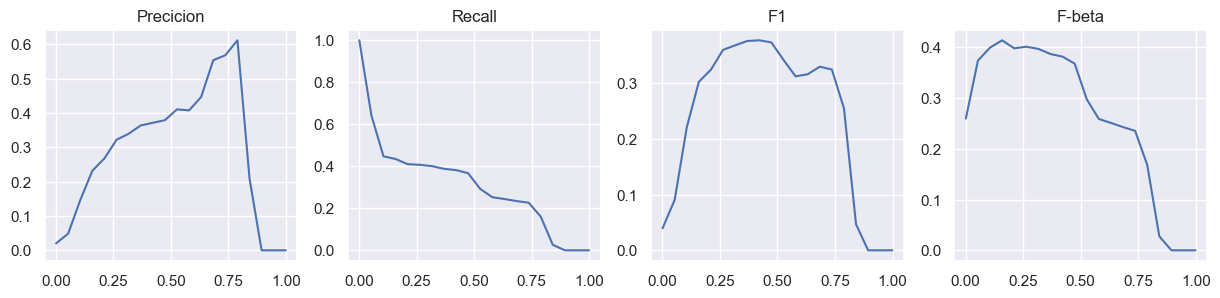

In [80]:
# best_params_no_users = {'n_estimators': 288, 'max_depth': 5, 'learning_rate': 0.022104570944915025, 'subsample': 0.5996351037653846, 'colsample_bytree': 0.7531337351786189, 'min_child_weight': 2, 'gamma': 0.28991742569304574, 'reg_alpha': 7.909371953418559, 'reg_lambda': 5.2117772508612985, 'scale_pos_weight': 5.706933634195327}
best_params_no_users = {'n_estimators': 321, 'max_depth': 4, 'learning_rate': 0.022029883317184456, 'subsample': 0.6032198341257682, 'colsample_bytree': 0.811054958759173, 'min_child_weight': 2, 'gamma': 0.4185327809074679, 'reg_alpha': 9.047825559667798, 'reg_lambda': 9.991007132661824, 'scale_pos_weight': 3.081360078594262}

best_pred_no_users, feature_imps_no_users = get_xgb_result_with_params(best_params_no_users, X_train_no_users, y_train, X_test_no_users, y_test)

In [83]:
from sklearn.metrics import classification_report
thr = 0.4
print_confusion_matrix(best_pred_no_users, thr, y_test)

report_dict = classification_report(y_test, (best_pred_no_users >= thr).astype(int), output_dict=True)
pd.DataFrame(report_dict)


	real 1	real 0
pred 1	1725	2959	
pred 0	2780	273570	


,0,1,accuracy,macro avg,weighted avg
precision,0.989940,0.368275,0.979579,0.679108,0.979975
recall,0.989299,0.382908,0.979579,0.686104,0.979579
f1-score,0.989620,0.375449,0.979579,0.682534,0.979775
support,276529.000000,4505.000000,0.979579,281034.000000,281034.000000


In [84]:
get_feature_to_importance(
    X_train_no_users.columns,
    feature_imps_no_users
)

incoming_tx_whole_fee_4_cnt 0.14661653
incoming_tx_fees_min 0.11574001
btc_sent_total 0.094785124
input_address_cnt 0.08735459
output_address_cnt 0.075620644
btc_received_max 0.06950354
incoming_tx_input_address_cnt_mean 0.06251208
outcoming_tx_output_address_cnt_mean 0.054143343
btc_sent_min 0.039663017
outcoming_tx_input_address_cnt_mean 0.037738807
outcoming_tx_whole_fee_4_cnt 0.035395116
big_inp_addr 0.034708552
btc_received_total 0.021735476
outcoming_tx_cnt 0.021038068
btc_received_mean 0.01961134
outcoming_tx_fees_total 0.01685834
incoming_tx_output_address_cnt_mean 0.012299692
incoming_tx_cnt 0.010950909
outcoming_tx_fees_max 0.008107311
incoming_tx_fees_max 0.006513661
btc_sent_gini 0.006146312
incoming_tx_ts_cnt 0.0059090303
outcoming_tx_ts_gini 0.0051135337
btc_received_gini 0.0045639914
btc_received_min 0.0034917928
outcoming_tx_fees_mean 0.0017164473
incoming_tx_ts_gini 0.000960635
btc_sent_max 0.00032764033
outcoming_tx_ts_cnt 0.0003142049
btc_sent_mean 0.00028669476
outc

# Random forest


        Best threshold: 0.053526315789473686
        Best F1: 0.18599774783520368, precicion: 0.11271649096385543, recall: 0.5316315205327414
        


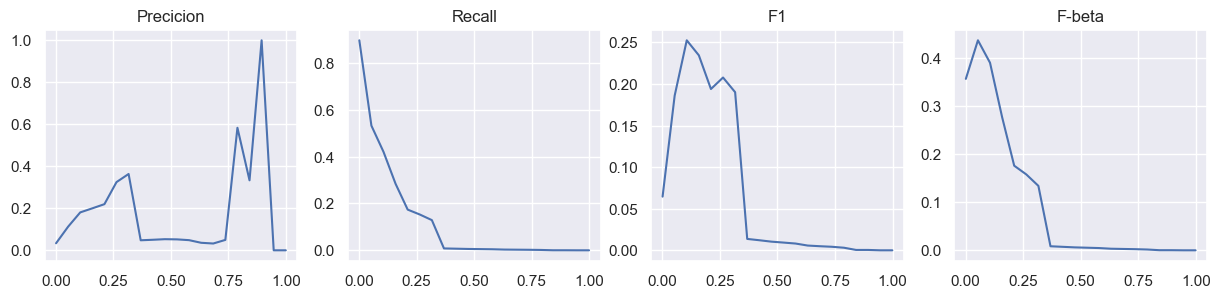

In [19]:
import xgboost as xgb

column_transformer = ColumnTransformer(
    transformers=[
        ('min_max_scale', MinMaxScaler(), list(set(X_train.columns))),
    ]
)

pipeline = Pipeline(steps=[
    ('transformers', column_transformer),
    ('xgb', RandomForestClassifier(n_estimators=150, class_weight={0: 1, 1: 30}))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_vals = model.predict(X_test)

res = get_best_threshold(y_pred, y_test, return_hists=True)

In [22]:
thr = 0.3
print_confusion_matrix(y_pred, thr, y_test)

report_dict = classification_report(y_test, (y_pred >= thr).astype(int), output_dict=True)
pd.DataFrame(report_dict)


	real 1	real 0
pred 1	585	1184	
pred 0	3920	275345	


,0,1,accuracy,macro avg,weighted avg
precision,0.985963,0.330695,0.981838,0.658329,0.975459
recall,0.995718,0.129856,0.981838,0.562787,0.981838
f1-score,0.990817,0.186484,0.981838,0.588650,0.977923
support,276529.000000,4505.000000,0.981838,281034.000000,281034.000000


In [85]:
wallets_feats = pd.read_csv("../dataset/custom/features_fixed/wallets_features_agg.csv")[["addrId", "class"]]


In [123]:
wallets_feats[wallets_feats["class"] == 1]["addrId"].sample(20)

758284    13ifz5muK4qjZvkhgYE3i2wqBZsKACftj4
307362    1Cmpd6z6SLGskKqBDXjcLjg9abR3At5trh
641660     1Htgk9kQsXvF93B2xFSaFZGpjZNc5JKwD
374879    1KY2kgVuscMAjge5vqBAgwTmsDSsf31Vo2
397997    16hJCmsCKyW7ycwM8urwGwtEdfXe8PuaLR
200296    13gL1bQKhxcMC8dHVztLKJK48cCzE8N2cP
243381    1L5UTTceW1R9UQSpPw5ebkNKbnNmNPEfbQ
396504    1GEEuK1BgX7z9Hx1g5RBm716D41Nxotyp8
261040    1FJ7Ny7gHL4j5UMkGnb4va5TjzvoiVtxyo
321185    1Grdi3chMounJpu9ZWVFoHecnC2QY6QWv1
170929    1Kn7yCgVFcxZhzcTgcXdzFez8NzSyb32s1
98194     1MQzeUEpoFpPssg4Vtnx8mk2xqaKwjH8KT
316298    1QA7gCL3ZmL1GfgFJSTvwXmKH5GsdKHYN1
292394    13R6TwsnBuG61TJYfrTVzZMXDctArStfRB
327425    158meK2xYj5vTVkSXiv3Qcq4W4SZGfxUSD
390640    1PgLc1hys3LSo5ahFT5megMG1KJaAckTbL
271201    1BsJqx5rZa49TDVMV96YJk154HdxD8kwEe
393032    12jxf45JirwyFU9CWprwGJcM4w2TQ5TbMZ
173170    1PAE2wmGEHUPnMV9J3VCBMyTFAY7pF5YpF
243007    1C8QmvLyU26VRDrAEcojBCw421hJbHTX5Y
Name: addrId, dtype: object

{'a'}

In [118]:
wallets_feats["dist_chars"] = wallets_feats["addrId"].apply(lambda x : len(set(x[:5].lower() + x[-5:].lower())))
wallets_feats

,addrId,class,dist_chars
0,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,3,9
1,13Lhad3SAmu2vqYg2dxbNcxH7LE77kJu2w,3,10
2,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,3,7
3,16zs5SVSyADh5WrLNbZbpRLsBsN5uEzgeK,3,8
4,1QJpwtUorBKPGUJkSyrRcBKTAHq4CXrdYh,3,10
...,...,...,...
822937,13h3xr1LJXQXn9QR3gio62xgdZYAoBrKYQ,3,9
822938,1Dow13WsGdCYewjtxP1acvM47A2XoPx1fF,3,7
822939,18rfNEMrpF4yqw3s2Y9jTSvsfiH6dYC7ph,3,10
822940,1Ct6Sx8uKTubXPcuLX5jSKb6QKMcqf1Ybj,3,9


<Axes: >

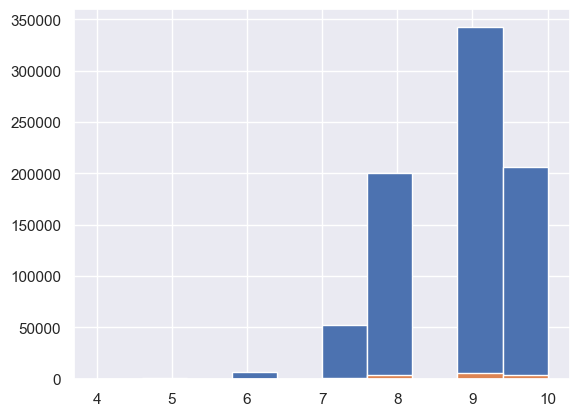

In [120]:
wallets_feats[wallets_feats["class"] != 1]["dist_chars"].hist()
wallets_feats[wallets_feats["class"] == 1]["dist_chars"].hist()


In [121]:
wallets_feats[wallets_feats["class"] != 1]["dist_chars"].value_counts()

dist_chars
9     342818
10    206387
8     200403
7      52524
6       6165
5        369
4         10
Name: count, dtype: int64

In [122]:
wallets_feats[wallets_feats["class"] == 1]["dist_chars"].value_counts()

dist_chars
9     6086
10    3625
8     3506
7      927
6      117
5        4
4        1
Name: count, dtype: int64